<a href="https://colab.research.google.com/github/topcat101-cmd/Nids-using-TranferLearning/blob/main/Nids_intrusion_detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
import pandas as pd
import numpy as np
from tensorflow import keras
#-------------------------------------------
import tensorflow as tf
#------------------------------------------
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


drive.mount('/content/drive')  #Loads the dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
path = 'drive/My Drive/Dataset/NSL-KDD' #The path to the drive, of where the datasets lay.
train = (path+ '/KDDTrain+.txt')
test = (path+ '/KDDTest+.txt')
test1 = (path+ '/KDDTest-21.txt')  #Loads the dataset

#Displays the features included for the algorinm
feature_included=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]


protocol_types=['tcp','udp','icmp']

services_types=['http','smtp','finger','domain_u','auth','telnet','ftp','eco_i','ntp_u','ecr_i','other','private','pop_3','ftp_data',
                  'rje','time','mtp','link','remote_job','gopher','ssh','name','whois','domain','login','imap4','daytime','ctf','nntp',
                  'shell','IRC','nnsp','http_443','exec','printer','efs','courier','uucp','klogin','kshell','echo','discard','systat',
                  'supdup','iso_tsap','hostnames','csnet_ns','pop_2','sunrpc','uucp_path','netbios_ns','netbios_ssn','netbios_dgm',
                  'sql_net','vmnet','bgp','Z39_50','ldap','netstat','urh_i','X11','urp_i','pm_dump','tftp_u','tim_i','red_i','icmp',
                  'http_2784','harvest','aol','http_8001']

binary_attack=['normal','ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan','back', 'land', 'neptune', 'pod', 'smurf',
               'teardrop', 'apache2', 'udpstorm', 'processtable','mailbomb','buffer_overflow', 'loadmodule', 'perl', 'rootkit',
               'xterm', 'ps', 'sqlattack','ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy', 'warezclient',
               'warezmaster','snmpgetattack','named', 'xlock', 'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']

# Dictionary that contains mapping of various attacks to the four main categories
#https://www.researchgate.net/figure/Attack-types-of-DoS-R2L-U2R-Probe-categories_tbl1_327110465

multiclass_attack={ 'normal': 'normal',
        'probe': ['ipsweep.', 'nmap.', 'portsweep.','satan.', 'saint.', 'mscan.'], #Probing attacks
        'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.','teardrop.', 'apache2.', 'udpstorm.', 'processtable.','mailbomb.'], #Denial of Service
        'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.','xterm.', 'ps.', 'sqlattack.'], #User to Root attack
        'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.','phf.', 'spy.', 'warezclient.', 'warezmaster.','snmpgetattack.', #Root to local attacks
                   'named.', 'xlock.', 'xsnoop.','sendmail.', 'httptunnel.', 'worm.', 'snmpguess.']}
#multiclass attack, which has a list within a dictornary for the attacks.

In [26]:
train_data=pd.read_csv(train,names=feature_included) #Read a comma-separated values (csv) file into DataFrame.
test_data=pd.read_csv(test,names=feature_included)#Read a comma-separated values (csv) file into DataFrame.
test_dat1=pd.read_csv(test1,names=feature_included)
print(train_data.head()) #prints out the data frame

#--------------------------------------------------------------------------------------------------
#DataFrame is a 2-dimensional labeled data structure with columns of potentially different types. -
#You can think of it like a spreadsheet or SQL table, or a dict of Series objects.                -
#It is generally the most commonly used pandas object                                             -
#https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html                             -
#--------------------------------------------------------------------------------------------------


#x_data = train_data.pop('protocol_type') #Gives me the entrys of protocol_type by removing it
print(train_data.loc[255]) #prints out the data frame ----- #loc allows you to find a specific row in your dataframe, giving the index

   duration protocol_type  ...    label difficulty
0         0           tcp  ...   normal         20
1         0           udp  ...   normal         15
2         0           tcp  ...  neptune         19
3         0           tcp  ...   normal         21
4         0           tcp  ...   normal         21

[5 rows x 43 columns]
duration                           0
protocol_type                   icmp
service                        ecr_i
flag                              SF
src_bytes                       1032
dst_bytes                          0
land                               0
wrong_fragment                     0
urgent                             0
hot                                0
num_failed_logins                  0
logged_in                          0
num_compromised                    0
root_shell                         0
su_attempted                       0
num_root                           0
num_file_creations                 0
num_shells                         0
num_a

In [27]:
print('Dimensions of the Training set:',train_data.shape)
print('Dimensions of the Test set:',test_data.shape)
print('Dimensions of the Test-21 set:',test_dat1.shape)
#we have so many rows and so many columns, this is importatnt to get the dimentions.

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)
Dimensions of the Test-21 set: (11850, 43)


In [28]:
#(train_images, train_labels), (test_images, test_labels), (test_images, test_labels) = fashion_mnist.load_data() #split into testing and training
#This would automatically split the data, into the datasets we need

In [29]:
print('Training dataset:')
print(train_data['label'].value_counts())
print('Test dataset:')
print(test_data['label'].value_counts())
print('Test dataset:')
print(test_dat1['label'].value_counts())

Training dataset:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64
Test dataset:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep

In [30]:
test_dat1.head() #puts it out in a graph

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,13,tcp,telnet,SF,118,2425,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.0,0.0,26,10,0.38,0.12,0.04,0.0,0.00,0.00,0.12,0.3,guess_passwd,2
1,0,udp,private,SF,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,0.0,0.0,0.0,0.0,0.75,0.5,0.0,255,254,1.00,0.01,0.01,0.0,0.00,0.00,0.00,0.0,snmpguess,12
2,0,tcp,telnet,S3,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,1.0,0.0,0.0,1.00,0.0,0.0,255,79,0.31,0.61,0.00,0.0,0.21,0.68,0.60,0.0,processtable,18
3,0,udp,private,SF,53,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.0,0.0,255,255,1.00,0.00,0.87,0.0,0.00,0.00,0.00,0.0,normal,17
4,0,tcp,private,SH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,1.0,0.0,0.0,1.00,0.0,0.0,16,1,0.06,1.00,1.00,0.0,1.00,1.00,0.00,0.0,nmap,17


In [31]:
test_dat1.describe()#gives us diffrent calculation in a chart, such as count, mean, std, min, etc..

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty
count,11850.000000,1.185000e+04,1.185000e+04,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.0,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000
mean,415.439831,1.945644e+04,1.228105e+03,0.000591,0.016034,0.001350,0.190211,0.041181,0.253080,0.227679,0.004304,0.000506,0.218059,0.016203,0.002194,0.003882,0.0,0.000928,0.052911,94.116118,48.269451,0.113841,0.114590,0.274313,0.268355,0.753008,0.157149,0.096762,213.945401,117.541603,0.539597,0.148986,0.206493,0.024465,0.104181,0.106697,0.263952,0.252209,15.326835
std,1919.441623,6.519865e+05,2.389603e+04,0.024299,0.196379,0.050299,1.222392,0.205401,0.434795,10.025774,0.065465,0.029046,11.090938,0.933202,0.066210,0.076763,0.0,0.030455,0.223866,153.418960,119.213908,0.305945,0.309216,0.430353,0.430249,0.399044,0.338761,0.278665,82.203728,106.563438,0.423370,0.288758,0.379193,0.114234,0.265086,0.278549,0.377337,0.403039,4.407479
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,255.000000,12.000000,0.070000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
50%,0.000000,2.800000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,83.000000,0.530000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,17.000000
75%,1.000000,1.600000e+02,9.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,132.000000,16.000000,0.000000,0.000000,0.840000,0.797500,1.000000,0.060000,0.000000,255.000000,250.000000,1.000000,0.070000,0.090000,0.000000,0.010000,0.000000,0.560000,0.520000,18.000000
max,57715.000000,6.282565e+07,1.288652e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,1.000000,2.000000,878.000000,100.000000,5.000000,4.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000


In [32]:
train_data['num_outbound_cmds'].value_counts()

0    125973
Name: num_outbound_cmds, dtype: int64

In [33]:
test_data['num_outbound_cmds'].value_counts()

0    22544
Name: num_outbound_cmds, dtype: int64

In [34]:
test_dat1['num_outbound_cmds'].value_counts()

0    11850
Name: num_outbound_cmds, dtype: int64

In [35]:
train_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19


In [36]:
def graph(feature):
    test_data[feature].value_counts().plot(kind="bar")

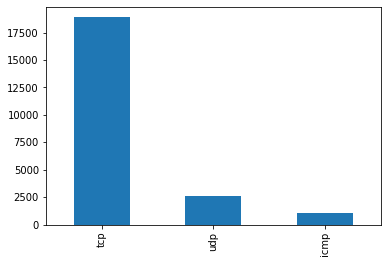

In [37]:
graph('protocol_type')


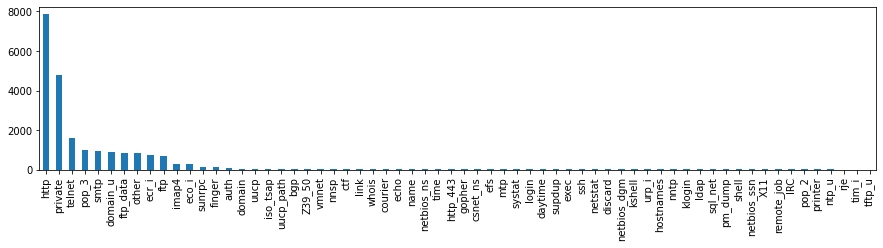

In [38]:
plt.figure(figsize=(15,3))
graph('service')

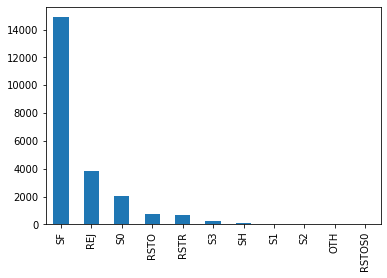

In [39]:
graph('flag')


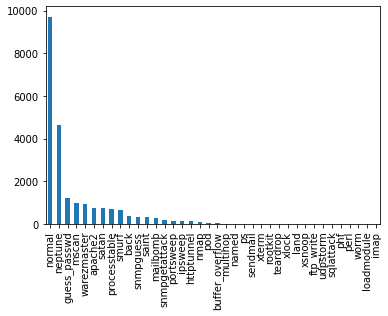

In [40]:
graph('label')

Data Handleing, From (https://github.com/mahbubhimel/Intrusion-Detection-System-Using-Convolutional-Neural-Network/blob/main/CNN_Intrusion_Detection.ipynb)

In [41]:
def preprocessing(data,cls,df):
  
#----------attack categorization----------------->
  data['label']=data['label'].replace(['normal.','normal'],0)

#----------------------binary classification--------------------->
  if cls=='binary':
    for i in range(len(binary_attack)):
      data['label'] = data['label'].replace(binary_attack[i], 1)
  
#---------------multiclass classification-------------------->  
  elif cls=='multiclass':
    for i in range(len(multiclass_attack['probe'])):
      data['label']=data['label'].replace([multiclass_attack['probe'][i],multiclass_attack['probe'][i][:-1]],1)
    
    for i in range(len(multiclass_attack['dos'])):
      data['label']=data['label'].replace([multiclass_attack['dos'][i],multiclass_attack['dos'][i][:-1]],2)
    
    for i in range(len(multiclass_attack['u2r'])):
      data['label']=data['label'].replace([multiclass_attack['u2r'][i],multiclass_attack['u2r'][i][:-1]],3)
    
    for i in range(len(multiclass_attack['r2l'])):
      data['label'] = data['label'].replace([multiclass_attack['r2l'][i],multiclass_attack['r2l'][i][:-1]],4)
#------------------------------------------------>


#-------------------------splitting features and labels---------------->
  y=data['label']
  x=data.loc[:,'duration':'hot']
#---------------------------------------------------------------------->


#-----------------------------------converting string objects to int------------------------>


#-----------------converting to binary feature vectors-------------------------------------->  
  t=x.protocol_type.copy()
  t=pd.get_dummies(t)
  x=x.drop(columns='protocol_type',axis=1)
  x=x.join(t)

  t1=x.service.copy()
  t1=pd.get_dummies(t1)
  x=x.drop(columns='service',axis=1)
  x=x.join(t1)

  t2=x.flag.copy()
  t2=pd.get_dummies(t2)
  x=x.drop(columns='flag',axis=1)
  x=x.join(t2)

#-----------------converting to binary label vectors--------------------------------------> 
  yt=y.copy()
  yt=pd.get_dummies(yt)
#------------------------------------------------------------------------------>

  x = MinMaxScaler(feature_range=(0, 1)).fit_transform(x)

  if df=='train':
    return x,yt
  else:
    return x,y



In [42]:
x_train,Y_train=preprocessing(train_data,cls='binary',df='train')
x_test,Y_test=preprocessing(test_data,cls='binary',df='test')
x_21_test, y_21_test = preprocessing(test_dat1, cls = 'binary', df = 'test21')

In [44]:
print('Dimensions of the Training set:',x_train.shape)
print('Dimensions of the Test set:',x_test.shape)
print('Dimensions of the Test-21 set:',x_21_test.shape)
#https://github.com/mahbubhimel/Intrusion-Detection-System-Using-Convolutional-Neural-Network/blob/main/CNN_Intrusion_Detection.ipynb

Dimensions of the Training set: (125973, 91)
Dimensions of the Test set: (22544, 85)
Dimensions of the Test-21 set: (11850, 83)


In [45]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(125973, 91, 1)

In [46]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(22544, 85, 1)

In [47]:
x_21_test = np.reshape(x_21_test, (x_21_test.shape[0], x_21_test.shape[1], 1))
x_21_test.shape

(11850, 83, 1)

In [49]:
x_train = x_train / 255.0

x_test = x_test / 255.0

x_21_test = x_21_test / 255.0

The ConvNet model


In [47]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])

#would be used to modify for the purpose of the model

In [48]:
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

NameError: ignored

In [ ]:
#https://www.auditmypc.com/tcp-port-8001.asp #https://github.com/mahbubhimel/Intrusion-Detection-System-Using-Convolutional-Neural-Network/blob/main/CNN_Intrusion_Detection.ipynb
#etection Rate (DR), False Alarm Rate (FAR) and accuracy (Acc%) #  

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])